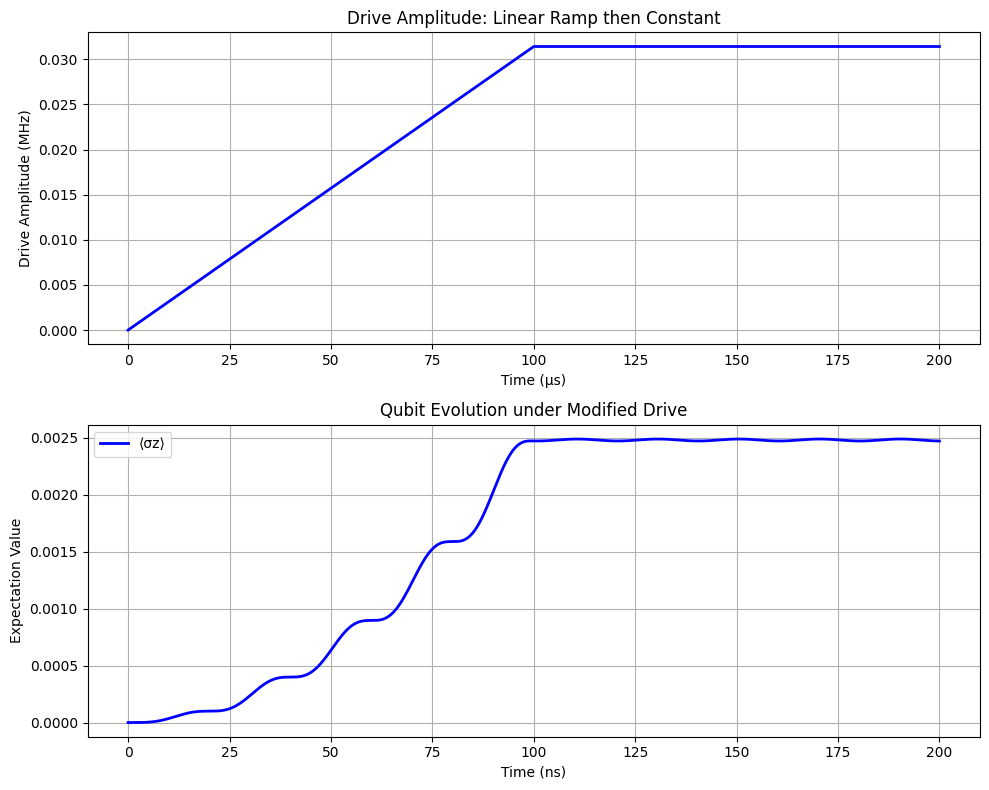

Final state: Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.99330778+0.10424496j]
 [-0.04945505-0.00518048j]]
Final population in excited state: 0.0025


In [25]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# System parameters
detuning = 100e-3 * 2 * np.pi  # 20 MHz detuning (Hz)
max_amplitude = 5e-3 * 2 * np.pi  # 5 MHz maximum drive amplitude (Hz)
T_total = 1e2  # Duration of the linear ramp (first part)
omega_0 = 5 * 2 * np.pi  # Qubit frequency (5 GHz)

# Extended total time (linear ramp + constant drive)
total_time = 2 * T_total

# Time array for simulation from 0 to 2*T_total
tlist = np.linspace(0, total_time, 2000)

# Define Pauli operators
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.num(2)

# Piecewise drive amplitude function: linear ramp for t <= T_total, constant afterwards
def drive_amplitude(t, args):
    """
    Drive amplitude:
      - For 0 <= t <= T_total: ramps linearly from 0 to max_amplitude.
      - For T_total < t <= 2*T_total: remains at max_amplitude.
    """
    if t <= T_total:
        return (max_amplitude / T_total) * t
    else:
        return max_amplitude

# Time-dependent Hamiltonian
# H = (detuning/2) * σz + (Ω(t)/2) * σx
H = [
    (detuning / 2) * sz,          # Detuning term
    [sx / 2, drive_amplitude]     # Time-dependent drive term
]

# Initial state (ground state)
psi0 = qt.basis(2, 0)

# Solve the time evolution
result = qt.mesolve(H, psi0, tlist)

expect_z = qt.expect(sz, result.states)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot drive amplitude over time
drive_values = [drive_amplitude(t, None) for t in tlist]
ax1.plot(tlist, drive_values, 'b-', linewidth=2)
ax1.set_xlabel('Time (μs)')
ax1.set_ylabel('Drive Amplitude (MHz)')
ax1.set_title('Drive Amplitude: Linear Ramp then Constant')
ax1.grid(True)

ax2.plot(tlist, expect_z, 'b-', label='⟨σz⟩', linewidth=2)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Expectation Value')
ax2.set_title('Qubit Evolution under Modified Drive')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final state
print(f"Final state: {result.states[-1]}")
print(f"Final population in excited state: {qt.expect(qt.num(2), result.states[-1]):.4f}")


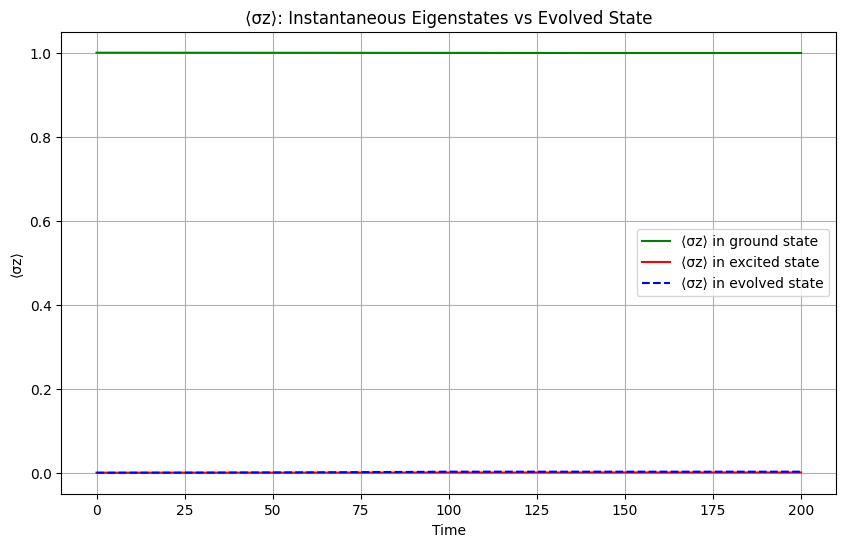

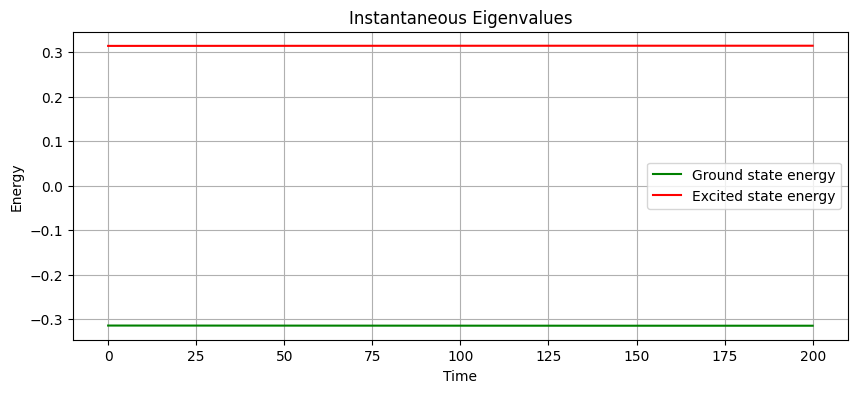

In [26]:
# --- New Cell: Instantaneous Eigenstates and sz Expectation ---
# Function to compute instantaneous eigenstates at time t
def compute_instantaneous_eigenstates(t):
    omega_t = drive_amplitude(t, None)
    # Hamiltonian in matrix form
    H_matrix = np.array([
        [detuning/2, omega_t/2],
        [omega_t/2, -detuning/2]
    ])
    eigenvals, eigenvecs = np.linalg.eigh(H_matrix)
    # Sort by eigenvalue
    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    # Convert to Qobj
    ground = qt.Qobj(eigenvecs[:, 0], dims=[[2], [1]])
    excited = qt.Qobj(eigenvecs[:, 1], dims=[[2], [1]])
    return eigenvals, ground, excited

# Arrays to store results
ground_sz = []
excited_sz = []
eigenvalues = []
for t in tlist:
    evals, g, e = compute_instantaneous_eigenstates(t)
    ground_sz.append(qt.expect(sz, g))
    excited_sz.append(qt.expect(sz, e))
    eigenvalues.append(evals)
eigenvalues = np.array(eigenvalues)

# Plot sz in instantaneous ground and excited states
plt.figure(figsize=(10, 6))
plt.plot(tlist, ground_sz, 'g-', label='⟨σz⟩ in ground state')
plt.plot(tlist, excited_sz, 'r-', label='⟨σz⟩ in excited state')
plt.plot(tlist, expect_z, 'b--', label='⟨σz⟩ in evolved state')
plt.xlabel('Time')
plt.ylabel('⟨σz⟩')
plt.title('⟨σz⟩: Instantaneous Eigenstates vs Evolved State')
plt.legend()
plt.grid(True)
plt.show()

# Plot instantaneous eigenvalues
plt.figure(figsize=(10, 4))
plt.plot(tlist, eigenvalues[:, 0], 'g-', label='Ground state energy')
plt.plot(tlist, eigenvalues[:, 1], 'r-', label='Excited state energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Instantaneous Eigenvalues')
plt.legend()
plt.grid(True)
plt.show()